<a href="https://colab.research.google.com/github/jhios98/npl/blob/main/project_nlp_hios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROYECTO NLP CODER HOUSE**

## Objetivos

Durante el desarrollo del proyecto, mediante la aplicación de NLP, se espera alcanzar los siguientes objetivos:

1. Conocer las herramientas y aplicaciones de las distintas librerías y módulos de NLP vistos en clase para abordar un problema de análisis de sentimientos.
2. Desarrollar el análisis, la comprensión y la limpieza de los documentos procedentes de las "reviews" de usuarios de vehículos.
3. Construir un modelo que clasifique de manera efectiva y óptima la opinión de un usuario respecto de un vehículo a partir del entrenamiento del conjunto de datos seleccionado.
4. Afrontar el resto de la utilización de las nuevas herramientas y la búsqueda de información adicional para su correcta ejecución.

# IMPORTAR LIBRERIAS REQUERIDAS PARA EL DESARROLLO

In [ ]:
import pandas as pd
import numpy as np
import string
import itertools
import matplotlib.pyplot as plt

import nltk
from wordcloud import WordCloud
from nltk import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer, LancasterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

porter = PorterStemmer()
lancaster = LancasterStemmer()
lemmatizer = WordNetLemmatizer()

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, classification_report, confusion_matrix, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# LECTURA Y ANÁLISIS BÁSICO


## lectura de la base de datos

In [ ]:
# URL directa al archivo CSV en el repositorio de GitHub
url_2 = "https://raw.githubusercontent.com/jhios98/npl/refs/heads/main/Car_Reviews.csv"
car_data = pd.read_csv(url_2)
car_data.shape

(10678, 3)

In [ ]:
car_data.head()

,Vehicle_Title,Review,Recommend
0,2006 Hyundai Azera Sedan Limited 4dr Sedan (3....,Electrical nightmare. Dealer cost for repair...,No
1,2006 Hyundai Azera Sedan Limited 4dr Sedan (3....,"I traded out of my Acura due to gas prices, o...",No
2,2006 Hyundai Azera Sedan Limited 4dr Sedan (3....,Gas mileage is terrible. No front seat driver...,No
3,2012 Hyundai Azera Sedan 4dr Sedan (3.3L 6cyl 6A),Warning Do not buy Hyundai Azera. It has engi...,No
4,2007 Hyundai Azera Sedan Limited 4dr Sedan (3....,I was a big advocate of my Hyundai azera. I d...,No


In [ ]:
car_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10678 entries, 0 to 10677
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Vehicle_Title  10678 non-null  object
 1   Review         10678 non-null  object
 2   Recommend      10678 non-null  object
dtypes: object(3)
memory usage: 250.4+ KB


In [ ]:
car_data.describe()

,Vehicle_Title,Review,Recommend
count,10678,10678,10678
unique,3249,10657,2
top,2001 Kia Rio Sedan 4dr Sedan (1.5L 4cyl 5M),Traded in my Chrysler 300C for this SUV becau...,No
freq,46,2,5339


## Análisis básico de Reviews

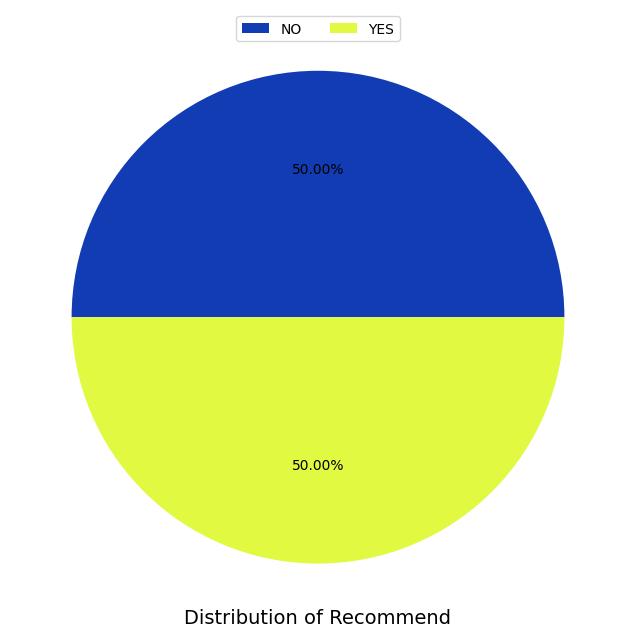

In [ ]:
plt.figure(figsize = (8, 8))

labels = ['NO', 'YES']
colors = ['#123cb4', '#e2f941']
plt.pie(car_data['Recommend'].value_counts(), autopct='%0.2f%%',colors=colors)

plt.title('Distribution of Recommend', size=14, y=-0.01)
plt.legend(labels, ncol=2, loc=9)
plt.show()

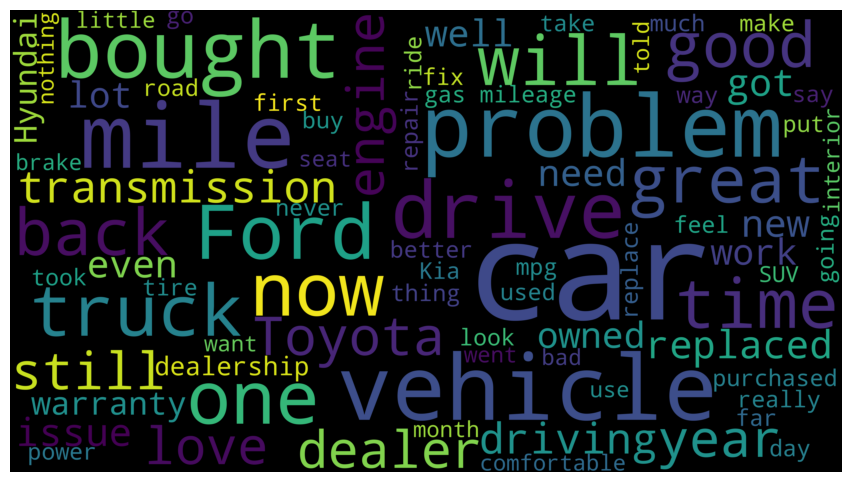

In [ ]:
word_cloud_text = ''.join(car_data.Review)
wordcloud = WordCloud(
    max_font_size=150,
    max_words=80,
    background_color="black",
    scale=10,
    width=900,
    height=500
).generate(word_cloud_text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0, 0.5, 'Frecuencia')

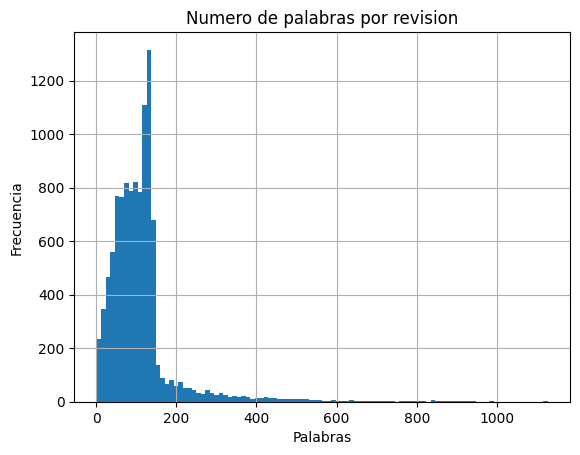

In [ ]:
words_per_review = car_data.Review.apply(lambda x: len(x.split(" ")))
words_per_review.hist(bins = 100)
plt.title('Numero de palabras por revision')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

In [ ]:
words_per_review.describe()

,Review
count,10678.000000
mean,111.687769
std,93.212803
min,2.000000
25%,63.000000
50%,100.000000
75%,130.000000
max,1127.000000


Al revisar los documentos o las reseñas, se observa que la base de datos está perfectamente balanceada en cuanto a la etiqueta 'Recommend'. Esto no suele ser común en escenarios reales; sin embargo, dado que se trata de un ejercicio de comprensión y aplicación de las librerías, se comprenden los problemas y las limitaciones que se pueden presentar con datos del día a día.

Considerando lo anterior, se identifica que existen ciertas palabras relevantes dentro de los documentos que efectivamente se pueden asociar a un tipo de sentimiento, como 'problem', 'good', y otras que simplemente se refieren al objeto de la calificación, en este caso vehículos, así como las marcas relacionadas. Además, se observa que los documentos tienen en promedio 111 palabras, con un mínimo de 2 y un máximo de 1127.

Preprocesamiento

In [ ]:
car_data['Review_proc'] = car_data.Review.apply(lambda x: x.lower())
car_data.head(5)

,Vehicle_Title,Review,Recommend,Review_proc
0,2006 Hyundai Azera Sedan Limited 4dr Sedan (3....,Electrical nightmare. Dealer cost for repair...,No,electrical nightmare. dealer cost for repair...
1,2006 Hyundai Azera Sedan Limited 4dr Sedan (3....,"I traded out of my Acura due to gas prices, o...",No,"i traded out of my acura due to gas prices, o..."
2,2006 Hyundai Azera Sedan Limited 4dr Sedan (3....,Gas mileage is terrible. No front seat driver...,No,gas mileage is terrible. no front seat driver...
3,2012 Hyundai Azera Sedan 4dr Sedan (3.3L 6cyl 6A),Warning Do not buy Hyundai Azera. It has engi...,No,warning do not buy hyundai azera. it has engi...
4,2007 Hyundai Azera Sedan Limited 4dr Sedan (3....,I was a big advocate of my Hyundai azera. I d...,No,i was a big advocate of my hyundai azera. i d...


In [ ]:
token_lists = [word_tokenize(each) for each in car_data.Review]
tokens = [item for sublist in token_lists for item in sublist]
print("Numero de tokens unicos antes: ", len(set(tokens)))

token_lists_lower = [word_tokenize(each) for each in car_data.Review_proc]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Numero de tokens unicos nuevos: ", len(set(tokens_lower)))


print("Disminución en el numero de tokens unicos luego de normalizar las palabar a minusculas:", (((len(set(tokens_lower)) / len(set(tokens))) -1)*100))

Numero de tokens unicos antes:  36970
Numero de tokens unicos nuevos:  31294
Disminución en el numero de tokens unicos luego de normalizar las palabar a minusculas: -15.352988909926967


In [ ]:
# Seleccionando los caracteres no alfa numericos que no son espacios
special_chars = car_data.Review_proc.apply(lambda x: [each for each in list(x) if not each.isalnum() and each != ' '])

# obtener una lista de listas
flat_list = [item for sublist in special_chars for item in sublist]

# caracteres especiales unicos
print(set(flat_list))
print(len(flat_list))

{'_', '\x91', '{', '=', '}', '\t', '\r', '😤', '\u200b', ';', '?', '.', '*', '′', '–', '‘', '😭', '`', '🎤', '•', '/', '😕', '@', '\x96', '<', '\x97', '\u202c', "'", '“', '!', '\x92', '\\', '\xa0', '’', '^', '…', '$', '°', '+', '(', ']', ',', '🤥', '\x93', '\u200e', '"', ':', ')', '#', '>', '—', '-', '¥', '\u202a', '”', '~', '\x94', '\x85', '[', '&', '\x7f', '%'}
198005


In [ ]:
freq_all_word = nltk.FreqDist(flat_list)
freq_all_word = pd.DataFrame(list(freq_all_word.items()), columns = ["Word","Frequency"])
freq_all_word.sort_values('Frequency',ascending=False, inplace = True)
freq_all_word.reset_index(drop = True, inplace=True)
freq_all_word.head(15)

,Word,Frequency
0,.,83930
1,",",43731
2,',16989
3,\r,12339
4,!,8098
5,-,7464
6,),4586
7,(,4433
8,"""",3778
9,/,3015


Tras analizar la frecuencia de caracteres especiales en tu conjunto de datos, se observa que ciertos caracteres aparecen con mucha mayor frecuencia que otros. El punto (.), la coma (,) y el apóstrofe (') son los más frecuentes, lo cual es probable que se deba a su uso común en la estructura de oraciones y contracciones. La presencia de '\r' (retorno de carro) sugiere posibles saltos de línea o formato dentro de los datos de texto. Además, los signos de exclamación (!), guiones (-), paréntesis (()), comillas (") y barras diagonales (/) también son relativamente frecuentes, lo que posiblemente refleja un lenguaje expresivo y convenciones de formato específicas. Los caracteres menos frecuentes, como los signos de dólar ($), los signos de interrogación (?), los dos puntos (:), los signos de y comercial (&) y los puntos y coma (;), pueden indicar patrones lingüísticos menos comunes o entradas de datos específicas.

Implicaciones de mantener los caracteres especiales en el texto:

Mantener estos caracteres especiales en el texto puede tener implicaciones significativas para el análisis y modelado de los datos:

Ruido en los datos: Los caracteres especiales pueden introducir ruido en los datos si no se manejan adecuadamente. Por ejemplo, si se están utilizando técnicas de procesamiento de lenguaje natural (PNL), los caracteres especiales pueden interferir con la tokenización, el etiquetado gramatical y otras tareas.
Sesgo en los resultados: Algunos caracteres especiales pueden tener un significado semántico que puede afectar los resultados del análisis. Por ejemplo, los signos de exclamación pueden indicar emociones fuertes, mientras que los signos de interrogación pueden indicar incertidumbre. Si no se tiene en cuenta este significado, se puede introducir un sesgo en los resultados.
Dificultad para la interpretación: La presencia de muchos caracteres especiales puede dificultar la interpretación de los resultados del análisis. Por ejemplo, puede ser difícil identificar las palabras clave o los temas más importantes si el texto está lleno de ruido.

Remover signos de puntuación

In [ ]:
review_yes =car_data[car_data.Recommend == 'Yes']
review_no = car_data[car_data.Recommend == 'No']

In [ ]:
def process_review(word):

    stopwords_english = stopwords.words('english')

    # tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
    #                            reduce_len=True)
    # word_tokens = tokenizer.tokenize(word)
    word_tokens = word_tokenize(word)

    word_clean = []
    for word in word_tokens:
        if (word not in stopwords_english and word not in string.punctuation):
            word_clean.append(word)

    return word_clean

In [ ]:
preview_clean_y = []
for each in review_yes.Review_proc:
    preview_clean_y.append(process_review(each))

preview_clean_n = []
for each in review_no.Review_proc:
    preview_clean_n.append(process_review(each))

In [ ]:
all_words_y = list(itertools.chain(*preview_clean_y))
all_words_n = list(itertools.chain(*preview_clean_n))

In [ ]:
special_chars = [char for char in all_words_y if not char.isalnum() and char != ' ']

# caracteres especiales unicos
print(set(special_chars))
print(len(special_chars))

{'etune/bluetooth', '108,000', '30-35', '6-8', '24/30', 'spaciousness.could', 'outer/inner', 'parts/labor', 'that.the', 'it.so', 'though-', 'soul.we', '7.8', 'comfort.truly', 'tucson.great', 'door/head', '54,000', '23/25', '44.1', 'college-turns', "show'em", '16.9', 'luxurious.it', 'month.i', 'dry-rot', '3:73ls', '10-15k', '37.1', '5.5ft', '40+', 'in.i', '33-4', 'steps.anyway', 'd/t', '302.', 'back.the', 'driving.truck', 'water.seal', "'98", 'long-term', 'bit.', '21~22', '107,000', 'door.i', "'72", '34-40', 'quieter.time', '4.5+', 'term.as', 'i-pod', 'car-like', '3.3l', 'p/u', '85,000', 'nov-08', '~3yrs', 'sr5/trd', '75/25', 'bullet-proof', '36-38+', 'looks.update', '-why', 'disappointed.couple', '......', '8.112', '1/4mi', '28.8', 'is.the', 'all.make', '19.5.', 'carprousa.com', '20.7', 'nit-wit', '30.1', '1,300', 'car.overall', '8.5', '9/22/17', 'unevenly.the', 'days.it', 'limousine-like', '35,000.00', '158,000.00', '17-18mpg.we', 'smooth.it', 'transmission/ac', 'map/dome', '49,000', 

In [ ]:
special_chars = [char for char in all_words_n if not char.isalnum() and char != ' ']

# caracteres especiales unicos
print(set(special_chars))
print(len(special_chars))

{'oil-related', "'around", 'sporty\\sports', '108,000', 'idle.first', 'kbb.com', '30,000k', '30-35', 'failed.this', 'fix.shame', '2014.5.', '6-8', 'bench.at', 'tire.well', 'support.asking', 'it.so', '200.', 'own.if', 'warm-weather', 'though-', 'pedal-', 'desirable.most', 'expectations.within', 'hydro-locked', 'p.r', 'plugs-', 'location.gas', '54,000', 'should-which', '25,000mi', 'working/', '55mph+', 'reason.the', 'clicking/popping', '243.53', 'all.easy', 'whatsoever.am', 'month.i', 'work.both', 'stutters/jumps/throws', 'vehicle.', 'one-fabulous', '30-40', 'loaner/', '2001,2009', 'fine.waiting', '40+', 'dash/floor', 'there.when', 'school/college', 'in.i', 'clunking/clicking', 'high-pitched', 'back.the', 'car.meanwhile', 'ca.threw', "'98", 'long-term', '107,000', '13500.', 'off.i', 'abs/traction', 'button-operated', 'system.the', 'winter.oil', 'block.i', 'trans.', 'ordinary.i', '290,000.', 'household.update', 'speaker.12', 'dallas/fort', 'them.this', 'smooth1,2,3,4,5,6', 'car-like', '10

Tras eliminar los signos de puntuación, nuestro análisis de los caracteres especiales, clasificados según la recomendación (positiva o negativa), reveló una alta frecuencia de combinaciones alfanuméricas. Estas combinaciones, si bien pueden introducir ruido en el análisis, podrían contener pistas valiosas para diferenciar entre recomendaciones positivas y negativas.

In [ ]:
freq_words = nltk.FreqDist(all_words_y)
freq_words = pd.DataFrame(list(freq_words.items()), columns = ["Word","Frequency"])
freq_words.sort_values('Frequency',ascending=False, inplace = True)
freq_words.reset_index(drop = True, inplace=True)
freq_words.head(20)

,Word,Frequency
0,car,6343
1,great,2900
2,'s,2662
3,n't,2407
4,miles,2145
5,like,1824
6,drive,1782
7,vehicle,1758
8,love,1711
9,one,1685


In [ ]:
freq_words_n = nltk.FreqDist(all_words_n)
freq_words_n = pd.DataFrame(list(freq_words_n.items()), columns = ["Word","Frequency"])
freq_words_n.sort_values('Frequency',ascending=False, inplace = True)
freq_words_n.reset_index(drop = True, inplace=True)
freq_words_n.head(20)

,Word,Frequency
0,car,8466
1,n't,3577
2,ford,3401
3,miles,3140
4,'s,2477
5,transmission,2126
6,vehicle,2080
7,would,2074
8,new,2073
9,engine,1955


Comentarios Positivos:

Palabras más frecuentes: "car", "great", "'s", "n't", "miles", "like", "drive", "vehicle", "love", "one", "get", "good", "bought", "gas", "new", "truck", "mileage", "would", "driving", "mpg"
Sentimiento: Predominan palabras con connotaciones positivas como "great", "love", "good", "like", "enjoy". También se destacan términos relacionados con la experiencia de conducción ("drive", "driving", "miles", "mpg") y aspectos positivos del vehículo ("new", "truck", "mileage").

Comentarios Negativos:

Palabras más frecuentes: "car", "n't", "ford", "miles", "'s", "transmission", "vehicle", "would", "new", "engine", "get", "toyota", "bought", "one", "back", "dealer", "like", "problems", "problem", "replaced"
Sentimiento: Predominan palabras con connotaciones negativas como "problems", "problem", "replaced", "back", "dealer". También se observan marcas específicas como "ford" y "toyota" mencionadas con mayor frecuencia, lo que podría indicar problemas recurrentes con estas marcas.
Conclusiones:

Diferencias claras: Se observan diferencias significativas en el vocabulario utilizado en comentarios positivos y negativos.
Identificación de temas: Los comentarios positivos se centran en aspectos positivos de la experiencia de conducción y características del vehículo, mientras que los negativos se enfocan en problemas mecánicos, fallas, y experiencias negativas con el servicio al cliente (dealer).
Marcas específicas: La mención de marcas específicas como "ford" y "toyota" en los comentarios negativos sugiere posibles problemas recurrentes con estos fabricantes.

Text(0, 0.5, 'Frecuencia')

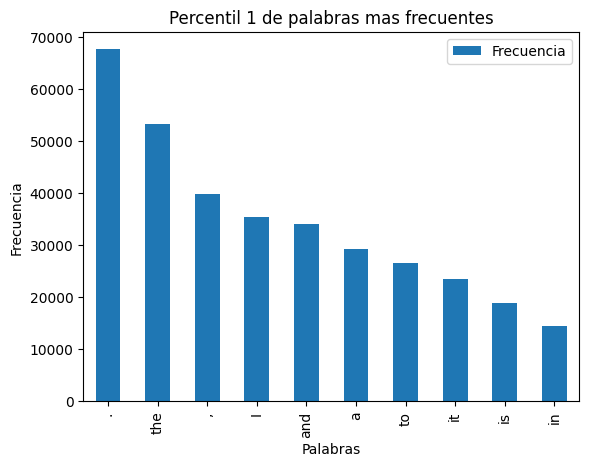

In [ ]:
one_percentile = int(len(set(all_words_y + all_words_n)) * 0.01)
top_1_percentile = Counter(tokens).most_common(one_percentile)
pd.DataFrame(top_1_percentile[:10], columns=['Palabras','Frecuencia']).set_index('Palabras').plot(kind='bar')
plt.title('Percentil 1 de palabras mas frecuentes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

Text(0, 0.5, 'Frecuencia')

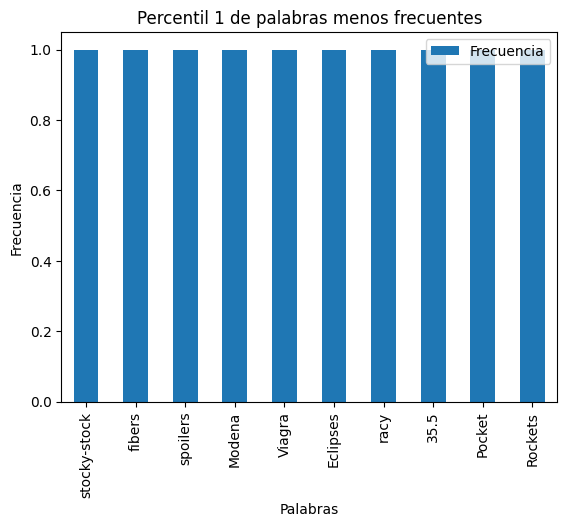

In [ ]:
one_percentile = int(len(set(all_words_y + all_words_n)) * 0.01)
bottom_1_percentile = Counter(tokens).most_common()[-one_percentile:]
pd.DataFrame(bottom_1_percentile[:10], columns=['Palabras','Frecuencia']).set_index('Palabras').plot(kind='bar')
plt.title('Percentil 1 de palabras menos frecuentes')
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')

In [ ]:
noise_words = []
noise_words.extend([word for word,val in top_1_percentile])
noise_words.extend([word for word,val in bottom_1_percentile])

Palabras Más Frecuentes:

Naturaleza: Principalmente artículos, preposiciones y conjunciones, que son comunes en cualquier texto.

Implicación: Estas palabras, aunque frecuentes, aportan poco valor semántico para la clasificación de reseñas como positivas o negativas.

Eliminación: En un análisis de sentimientos o clasificación de reseñas, estas palabras suelen eliminarse (stop words) para reducir la dimensionalidad y mejorar la precisión de los modelos.

Palabras Menos Frecuentes:


Naturaleza: Términos más específicos relacionados con características del vehículo, problemas mecánicos, experiencias de conducción, etc.

Implicación: Estas palabras pueden ser muy informativas para determinar si una reseña es positiva o negativa. Por ejemplo, palabras como "ruido", "falla", "excelente", "cómodo" suelen asociarse con reseñas negativas o positivas, respectivamente, sin embargo, son muy pocas sus apariciones, por lo que mantenerlas generaría un incremento en la dimensionalidad y el costo computacional.


Por ello, se agregan a una lista de palabras a eliminar del set de documentos.

# PROCESAMIENTO

In [ ]:
def process_review_data(review, stopwords_english, stem=False, lemma=False):
    # Tokenización de las palabras

    #tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
    #                            reduce_len=True)
    #word_tokens = tokenizer.tokenize(review)
    word_tokens = word_tokenize(review)

    # Crear un conjunto de todas las palabras
    all_words = list(itertools.chain(*word_tokens))
    one_percentile = int(len(set(all_words)) * 0.01)

    # Calcular las palabras más y menos frecuentes
    top_1_percentile = Counter(all_words).most_common(one_percentile)
    bottom_1_percentile = Counter(all_words).most_common()[-one_percentile:]

    # Generar la lista de palabras ruidosas (noise_words)
    noise_words = []
    noise_words.extend([word for word, _ in top_1_percentile])
    noise_words.extend([word for word, _ in bottom_1_percentile])

    # Combinar stopwords predeterminados y las palabras ruidosas
    stopwords_new = stopwords_english + noise_words

    # Filtrar y procesar las palabras
    previews_clean = []
    for word in word_tokens:
        if word not in stopwords_new and word not in string.punctuation:
            if not stem and not lemma:
                previews_clean.append(word)
            elif stem and not lemma:
                stemmer = PorterStemmer()
                previews_clean.append(stemmer.stem(word))

    return " ".join(previews_clean)  # Convertir la lista de palabras a una cadena

# Descargar las stopwords de NLTK (solo la primera vez)
stopwords_english = stopwords.words('english')


In [ ]:
car_data.loc[:, 'Review_clean'] = car_data['Review_proc'].apply(
    lambda x: process_review_data(x, stopwords_english, stem=False, lemma=False)
)

car_data.loc[:,'Recommend'] = car_data['Recommend'].replace({'Yes': 1, 'No': 0})

<ipython-input-70-b33c51d1c0a5>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  car_data.loc[:,'Recommend'] = car_data['Recommend'].replace({'Yes': 1, 'No': 0})


Dadas las observaciones encontradas en el analisis previo se establece una funcion función process_review_data realiza una limpieza de datos de reseñas o comentarios con el propósito de preparar la información para un análisis más efectivo. A continuación se describe su funcionamiento de manera sencilla:

Tokenización:

Se divide el texto en palabras individuales utilizando la función word_tokenize.

Cálculo de palabras frecuentes y poco frecuentes:

Se genera una lista con todas las palabras del texto.
Se calcula el 1% de las palabras más frecuentes y menos frecuentes basándose en la cantidad total de palabras únicas.

Generación de una lista de palabras ruidosas:

Se identifican las palabras más comunes y menos comunes como "ruidosas" o irrelevantes para el análisis.
Estas palabras se agregan a una lista junto con las stopwords predeterminadas de la biblioteca NLTK.

Filtrado y procesamiento de palabras:

Se eliminan las palabras ruidosas, stopwords, y signos de puntuación del texto.
Opcionalmente, se puede aplicar stemming (reducir las palabras a su raíz) usando el Porter Stemmer.

Resultado final:

La función devuelve una versión limpia del texto como una sola cadena, lista para su análisis.

Esta limpieza permite trabajar con datos más relevantes y eliminar elementos innecesarios que podrían sesgar el análisis.

In [ ]:
data_model = car_data[['Recommend','Review_clean']]

In [ ]:
data_model.head(10)

,Recommend,Review_clean
0,0,electrical nightmare dealer cost repairs thru ...
1,0,traded acura due gas prices rise took premium ...
2,0,gas mileage terrible front seat drivers side l...
3,0,warning buy hyundai azera engine problem stupi...
4,0,big advocate hyundai azera complain wait month...
5,0,excited azera tires went bad car months became...
6,0,never expected buy new car hear radio road noi...
7,0,fit finish nice find front driver's seat extre...
8,0,2002 nissan maxima se loved super car oldest s...
9,0,probably 15th car owned clunkers one takes cak...


Finalmente, se genera la base con cual se realizará la construcción y validación de modelos.

# MODELADO

In [ ]:
previews_list = list(data_model.Review_clean.values)
recomend_list = list(data_model.Recommend.values)

A continuación CountVectorizer se realiza una representación numérica de un conjunto de textos utilizando la técnica de Bag of Words, con esto se construye un vocabulario de todas las palabras únicas presentes en los textos.
Cuenta la frecuencia de cada palabra en cada texto.
Genera una matriz donde las filas representan los textos y las columnas las palabras del vocabulario.

In [ ]:
count_vector = CountVectorizer(ngram_range=(1, 1))
matrix_previews_cv = count_vector.fit_transform(previews_list)
all_words_cv = count_vector.get_feature_names_out()
print(count_vector.vocabulary_)

In [ ]:
x = matrix_previews_cv.toarray()
y = recomend_list

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
print(train_x.shape)
print(test_x.shape)

(8542, 21011)
(2136, 21011)


In [ ]:
print(len(train_y))
print(len(test_y))

8542
2136


## Regresión logistica

In [ ]:
params = {'fit_intercept': [True, False]}

score_metrics = {'f1': 'f1',
                 'accuracy': 'accuracy',
                 'recall': 'recall'}

clf = GridSearchCV(estimator=LogisticRegression(),
                   param_grid=params,
                   scoring=score_metrics,
                   refit='accuracy',
                   cv=5,
                   n_jobs=-1)

clf.fit(train_x, train_y)
y_pred = clf.predict(test_x)

conf_matrix = confusion_matrix(test_y, y_pred)

print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1101
           1       0.90      0.92      0.91      1035

    accuracy                           0.91      2136
   macro avg       0.91      0.91      0.91      2136
weighted avg       0.91      0.91      0.91      2136



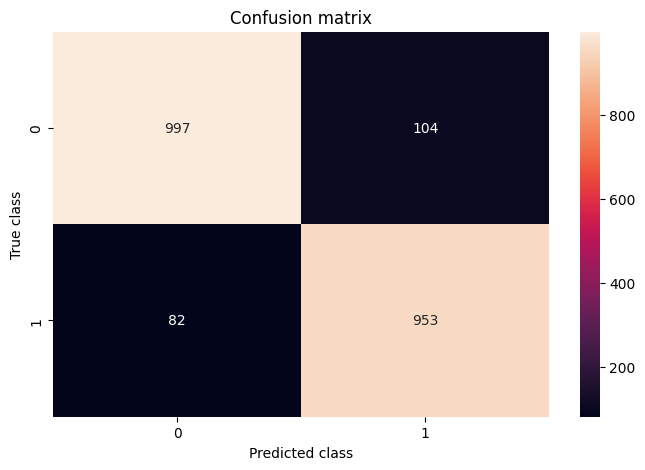

In [ ]:
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

El modelo de regresión tiene un desempeño sólido con métricas muy equilibradas entre las dos clases. Las métricas clave son las siguientes:

Precisión: 0.91 en promedio, con un rendimiento ligeramente mejor en la clase 0 (0.92) que en la clase 1 (0.90).
Exhaustividad: 0.91 en promedio, mostrando un buen equilibrio entre ambas clases, con una ligera ventaja en la clase 1 (0.92 frente a 0.91).
F1-Score: 0.91, lo que indica un buen balance entre precisión y recall, sin una inclinación significativa hacia ninguna de las clases.
Accuracy (Precisión global): 0.91, lo que refleja que el modelo acierta el 91% de las veces.
Promedio macro y ponderado (Macro Avg y Weighted Avg): Ambas métricas son 0.91, lo que sugiere que el modelo mantiene un rendimiento consistente y bien ajustado entre las clases, considerando su soporte respectivo.

En resumen, el modelo de regresión ofrece un rendimiento equilibrado y consistente, con métricas de precisión y recall similares para ambas clases. Con un desempeño del 91% en precisión global, el modelo es adecuado para tareas de clasificación donde el equilibrio entre las clases es importante y se necesita una alta tasa de aciertos.

## Random Forest

In [ ]:
param_grid = {
    'n_estimators': [20, 40],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

score_metrics = {'f1': 'f1',
                 'accuracy': 'accuracy',
                 'recall': 'recall'}

clf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring=score_metrics,
    refit='accuracy',
    cv=5,
    n_jobs=-1,
    error_score='raise'
)

clf_rf.fit(train_x, train_y)
y_pred = clf_rf.predict(test_x)

conf_matrix = confusion_matrix(test_y, y_pred)

print(classification_report(test_y, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.85      0.86      1101
           1       0.84      0.88      0.86      1035

    accuracy                           0.86      2136
   macro avg       0.86      0.86      0.86      2136
weighted avg       0.86      0.86      0.86      2136



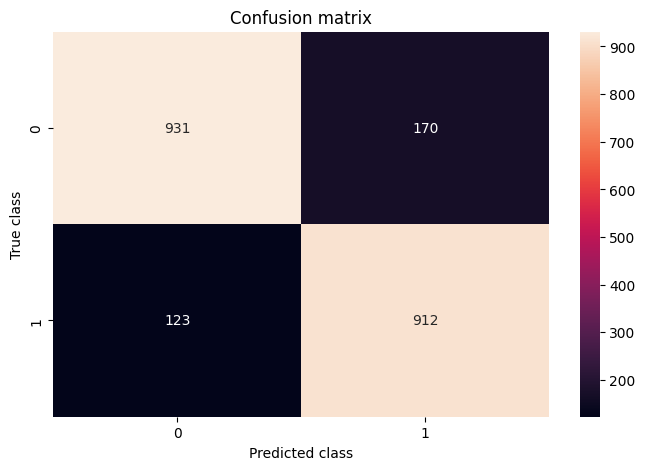

In [ ]:
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

el modelo Random Forest  tiene un desempeño sólido pero ligeramente inferior en comparación con otros modelos. Las métricas clave son las siguientes:

Precisión: 0.86 en promedio, con un rendimiento ligeramente mejor en la clase 0 (0.88) que en la clase 1 (0.84).
Exhaustividad: 0.86 en promedio, mostrando un rendimiento bastante equilibrado entre ambas clases, aunque la clase 1 tiene una ligera ventaja (0.88 frente a 0.85).
F1-Score: 0.86, lo que indica un buen equilibrio entre precisión y recall, sin una tendencia pronunciada a favorecer una clase sobre la otra.
Accuracy (Precisión global): 0.86, lo que refleja que el modelo acierta el 86% de las veces.

Promedio macro y ponderado (Macro Avg y Weighted Avg): Ambas métricas son 0.86, lo que indica que el modelo tiene un rendimiento consistente en ambas clases y ajustado al soporte de cada clase.

En resumen, el modelo Random Forest ofrece un rendimiento equilibrado, con una precisión y recall bastante similares en ambas clases. Aunque no es tan preciso como otros modelos, su desempeño sigue siendo adecuado para tareas con un balance razonable entre clases.

In [ ]:
best_estimator = clf.best_estimator_
importances = best_estimator.feature_importances_
all_words_cv = count_vector.get_feature_names_out()


df = pd.DataFrame({'feature': all_words_cv, 'importance': importances})


sorted_df = df.sort_values(by='importance', ascending=False).head(20)
selected_features = sorted_df['feature'].tolist()
selected_importances = sorted_df['importance'].tolist()

plt.figure(figsize=(15, 8))
sns.barplot(x=selected_features, y=selected_importances)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 20 Important Features')
plt.show()

Tfid


In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 1))
matrix_previews_tfidf = vectorizer.fit_transform(previews_list)
all_words_tfidf = vectorizer.get_feature_names_out()
print(vectorizer.vocabulary_)

{'electrical': 7257, 'nightmare': 12946, 'dealer': 6007, 'cost': 5515, 'repairs': 15588, 'thru': 18941, 'roof': 16048, 'honda': 9764, 'toyota': 19230, 'traded': 19265, 'acura': 2089, 'due': 7002, 'gas': 8839, 'prices': 14587, 'rise': 15946, 'took': 19128, 'premium': 14510, 'getting': 8931, 'miles': 12279, '94': 1813, '000': 1, 'kept': 10944, 'miss': 12389, 'handling': 9387, 'azera': 3079, 'limited': 11420, 'unstable': 19962, 'bouncy': 3758, '120': 200, 'mph': 12639, 'comfortably': 4988, 'handle': 9384, 'curves': 5832, 'well': 20652, 'transmission': 19345, 'difficulty': 6444, 'shifting': 16819, 'times': 19019, 'abs': 1913, 'work': 20939, 'snow': 17334, 'slid': 17176, 'lot': 11623, 'new': 12895, 'tires': 19050, 'get': 8923, '15': 326, 'mpg': 12635, 'driving': 6954, 'habits': 9332, 'one': 13329, 'knows': 11044, 'drive': 6933, 'likes': 11410, 'like': 11405, 'car': 4244, 'mileage': 12273, 'terrible': 18750, 'front': 8671, 'seat': 16511, 'drivers': 6944, 'side': 16963, 'leg': 11272, 'room': 

En el segundo enfoque, se utiliza TfidfVectorizer que realiza una representación numérica de un conjunto de textos, pero en lugar de contar solo la frecuencia de las palabras, aplica la técnica de TF-IDF (Term Frequency-Inverse Document Frequency). Esto significa que:

Construcción del vocabulario: Se crea un vocabulario de todas las palabras únicas presentes en los textos, similar a lo que hace el CountVectorizer, pero ponderando cada palabra según su frecuencia en un texto en relación con su frecuencia en todos los textos.

Cálculo de TF-IDF: Se calcula la importancia de cada palabra en un texto específico. Las palabras que aparecen con alta frecuencia en un texto, pero son menos comunes en los demás textos, tendrán un mayor valor de TF-IDF, mientras que las palabras comunes en todos los textos tendrán un valor bajo.

Generación de la matriz: Similar a CountVectorizer, se genera una matriz en la que las filas representan los textos y las columnas representan las palabras del vocabulario, pero con valores TF-IDF en lugar de simples conteos. Esto resalta las palabras más relevantes para cada texto.

Para este ejercicio, se trata de incrementar el parametro ngram_range, sin embargo, el colab no permite trabajar con un numero mucho más alto.

In [ ]:
x = matrix_previews_tfidf.toarray()
y = recomend_list

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
params = {'fit_intercept': [True, False]}

score_metrics = {'f1': 'f1',
                 'accuracy': 'accuracy',
                 'recall': 'recall'}

clf = GridSearchCV(estimator=LogisticRegression(),
                   param_grid=params,
                   scoring=score_metrics,
                   refit='accuracy',
                   cv=5,
                   n_jobs=-1)

clf.fit(train_x, train_y)
y_pred = clf.predict(test_x)

conf_matrix = confusion_matrix(test_y, y_pred)

print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1101
           1       0.91      0.91      0.91      1035

    accuracy                           0.92      2136
   macro avg       0.92      0.92      0.92      2136
weighted avg       0.92      0.92      0.92      2136



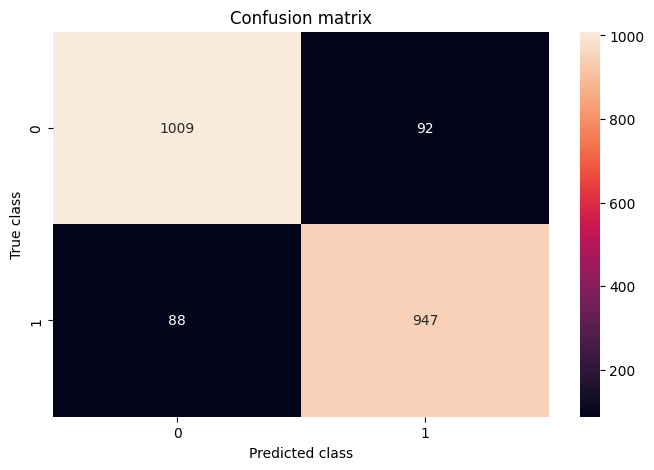

In [ ]:
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


El modelo de regresión utilizando TF-IDF ha mostrado un desempeño sobresaliente y equilibrado. Las métricas clave son las siguientes:

Precisión: 0.92 en promedio, con un rendimiento casi igual en ambas clases (0.92 para la clase 0 y 0.91 para la clase 1).
Exhaustividad: 0.92 en promedio, demostrando una identificación muy efectiva de ambas clases, sin una diferencia significativa entre ellas.
F1-Score: 0.92, lo que indica un excelente equilibrio entre precisión y recall para ambas clases.
Accuracy (Precisión global): 0.92, lo que refleja que el modelo acierta el 92% de las veces.
Promedio macro y ponderado (Macro Avg y Weighted Avg): Ambas métricas son 0.92, lo que indica que el modelo mantiene un rendimiento consistente en ambas clases y ajustado al soporte de cada una.

En resumen, el modelo de regresión utilizando TF-IDF tiene un rendimiento excepcional, con métricas de precisión, recall y F1-score equilibradas y altas en ambas clases. Este rendimiento es ideal para tareas donde la correcta clasificación y diferenciación entre clases es crucial, destacando especialmente por su capacidad para identificar palabras clave en los textos.

## RandomForest

In [ ]:
param_grid = {
    'n_estimators': [20, 40],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

score_metrics = {'f1': 'f1',
                 'accuracy': 'accuracy',
                 'recall': 'recall'}

clf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                   param_grid=param_grid,
                   scoring=score_metrics,
                   refit='accuracy',
                   cv=5,
                   n_jobs=-1)

clf.fit(train_x, train_y)
y_pred = clf.predict(test_x)

conf_matrix = confusion_matrix(test_y, y_pred)

print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85      1101
           1       0.83      0.87      0.85      1035

    accuracy                           0.85      2136
   macro avg       0.85      0.85      0.85      2136
weighted avg       0.85      0.85      0.85      2136



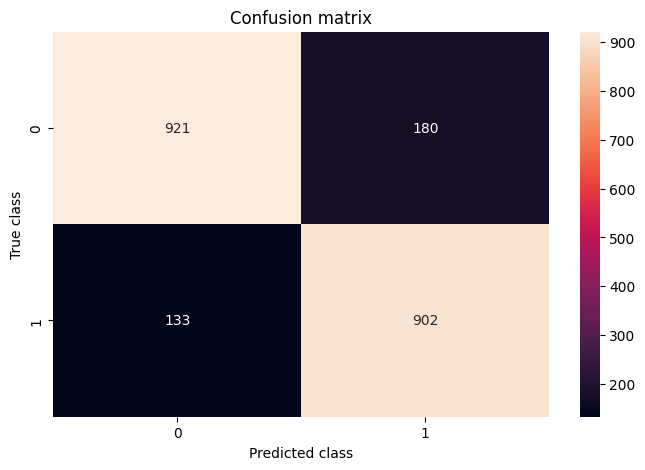

In [ ]:
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

El RandomForest utilizando TF-IDF aplicado a la base de datos de documentos muestra un desempeño equilibrado, pero con un margen de mejora en comparación con los resultados previos. Las métricas clave son las siguientes:

Precisión: 0.85 en promedio, con una ligera ventaja para la clase 0 (0.87) frente a la clase 1 (0.83).
Exhaustividad: 0.85 en promedio, con un rendimiento ligeramente mejor para la clase 1 (0.87) en comparación con la clase 0 (0.84).
F1-Score: 0.85 en promedio, lo que indica un buen equilibrio entre precisión y recall para ambas clases, sin una diferencia notable.
Accuracy (Precisión global): 0.85, lo que refleja que el modelo acierta el 85% de las veces.
Promedio macro y ponderado (Macro Avg y Weighted Avg): Ambas métricas son 0.85, lo que sugiere un rendimiento constante y balanceado en ambas clases, ajustado por el soporte de cada clase.

En resumen, el modelo con TF-IDF ha mostrado un desempeño sólido pero con algo más de variabilidad entre las clases en comparación con otros modelos. Aunque no alcanza los niveles más altos de precisión o recall, su rendimiento sigue siendo adecuado para tareas de clasificación de documentos, con un buen equilibrio entre ambas clases.

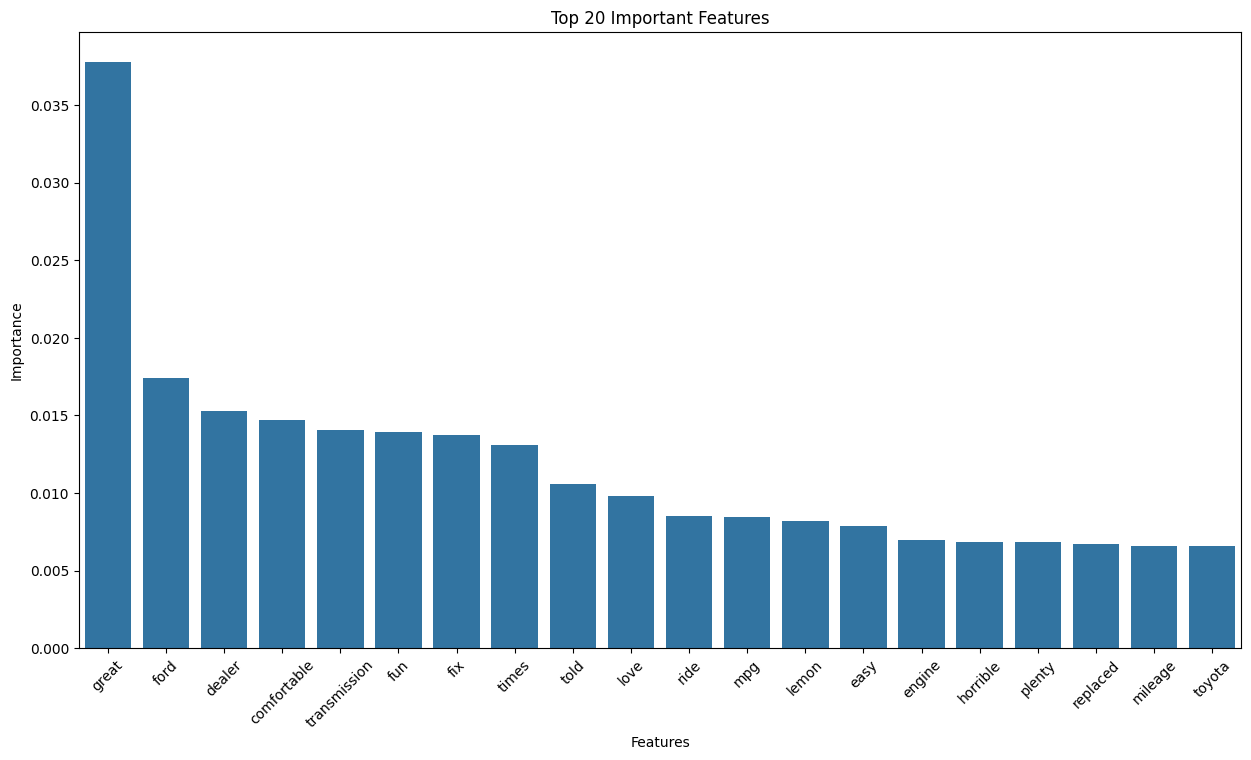

In [ ]:
best_estimator = clf.best_estimator_
importances = best_estimator.feature_importances_
all_words_cv = count_vector.get_feature_names_out()


df = pd.DataFrame({'feature': all_words_cv, 'importance': importances})


sorted_df = df.sort_values(by='importance', ascending=False).head(20)
selected_features = sorted_df['feature'].tolist()
selected_importances = sorted_df['importance'].tolist()

plt.figure(figsize=(15, 8))
sns.barplot(x=selected_features, y=selected_importances)
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Top 20 Important Features')
plt.show()



## CONCLUSÓN
El modelo de Regresión Logística utilizando TF-IDF tiene la mejor accuracy de 0.92, lo que lo convierte en el modelo más preciso entre todos. Además, este modelo mantiene un excelente equilibrio entre precisión, recall y F1-score en ambas clases, lo que indica que no solo es preciso, sino también efectivo para identificar correctamente las clases.

Por esta razón, se selecciona este modelo como el mejor, dada su precisión global del 92%. Este modelo tiene un desempeño sobresaliente, mostrando un equilibrio sólido entre precisión y recall en ambas clases, y es ideal para tareas de clasificación de documentos donde se busca alta precisión y un buen rendimiento general.

Sin embargo, es posible realizar una exploración y limpieza más profunda o analizar de alguna manera los sentimientos asociados a algún tipo de marca, o también probar con la eliminación de estos del documento. Sería interesante experimentar con un aumento de ngram_range o probar otras librerías especializadas en limpieza, como TweetTokenizer, que aunque se aplicó, no generó una gran mejora en los resultados.

Finalmente, concluyo que, a pesar de ser un problema básico, he aprendido y conocido significativamente durante el ejercicio. No obstante, siento que sienta una base sólida para una profundización y entrenamiento en un tema ampliamente utilizado y de gran valor en la industria en la actualidad.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 1))
matrix_previews_tfidf = vectorizer.fit_transform(previews_list)


all_words_tfidf = vectorizer.get_feature_names_out()
print(vectorizer.vocabulary_)


x = matrix_previews_tfidf.toarray()

y = recomend_list

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=42)
train_y = np.array(train_y)
test_y = np.array(test_y)

# Construcción de la red neuronal
model = Sequential()

# Usar Input Layer en vez de input_dim
model.add(Input(shape=(train_x.shape[1],)))  # Capa de entrada con la forma de los datos
model.add(Dense(50, activation='relu'))  # Capa oculta con 512 neuronas
model.add(Dropout(0.5))  # Regularización con Dropout

model.add(Dense(30, activation='relu'))  # Capa oculta con 256 neuronas
model.add(Dropout(0.5))  # Regularización con Dropout

# Capa de salida: 1 neurona (para clasificación binaria)
model.add(Dense(1, activation='sigmoid'))  # 'sigmoid' para clasificación binaria

# Compilación del modelo
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamiento del modelo
history = model.fit(train_x, train_y, epochs=5, batch_size=32, validation_data=(test_x, test_y), verbose=1)

# Evaluación del modelo
loss, accuracy = model.evaluate(test_x, test_y, verbose=0)

print(f'Precisión en los datos de prueba: {accuracy * 100:.2f}%')

# Si necesitas realizar predicciones:
predictions = model.predict(test_x)
